In [1]:
!pip install holidays


   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.0 MB 653.6 kB/s eta 0:00:02
   --- ------------------------------------ 0.1/1.0 MB 871.5 kB/s eta 0:00:02
   ------ --------------------------------- 0.2/1.0 MB 1.1 MB/s eta 0:00:01
   -------- ------------------------------- 0.2/1.0 MB 1.1 MB/s eta 0:00:01
   ---------- ----------------------------- 0.3/1.0 MB 1.1 MB/s eta 0:00:01
   ---------- ----------------------------- 0.3/1.0 MB 1.1 MB/s eta 0:00:01
   ------------ --------------------------- 0.3/1.0 MB 952.6 kB/s eta 0:00:01
   ---------------- ----------------------- 0.4/1.0 MB 1.1 MB/s eta 0:00:01
   ------------------- -------------------- 0.5/1.0 MB 1.1 MB/s eta 0:00:01
   -------------------- ------------------- 0.5/1.0 MB 1.1 MB/s eta 0:00:01
   ----------------------- ---------------- 0.6/1.0 MB 1.1 MB/s eta 0:00:01
   ----------------

In [2]:
!pip install skforecast

In [3]:
!pip install xgboost

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster


from skforecast.model_selection import backtesting_forecaster

import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter


#try xgboost
import xgboost as xgb


In [5]:
from google.colab import files
uploaded = files.upload()

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# load data
chor_training = pd.read_csv('chor_training_data.csv')
cle_training = pd.read_csv('cle_training_data.csv')
turi_training = pd.read_csv('turi_training_data.csv')
rod_training = pd.read_csv('rod_training_data.csv')



In [ ]:
def extractTemporalFeatures(df):
    df['Hour'] = df['Date'].dt.hour
    df['Day'] = df['Date'].dt.dayofyear
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['Weekday'] = df['Date'].dt.weekday


In [ ]:
chor_training['Date'] = pd.to_datetime(chor_training['Date'])
cle_training['Date'] = pd.to_datetime(cle_training['Date'])
turi_training['Date'] = pd.to_datetime(turi_training['Date'])
rod_training['Date'] = pd.to_datetime(rod_training['Date'])

extractTemporalFeatures(chor_training)
extractTemporalFeatures(cle_training)
extractTemporalFeatures(turi_training)
extractTemporalFeatures(rod_training)


chor_training = chor_training.set_index('Date')
cle_training = cle_training.set_index('Date')
turi_training = turi_training.set_index('Date')
rod_training = rod_training.set_index('Date')


chor_training.index = pd.to_datetime(chor_training.index)
cle_training.index = pd.to_datetime(cle_training.index)
turi_training.index = pd.to_datetime(turi_training.index)
rod_training.index = pd.to_datetime(rod_training.index)


In [ ]:
# fill missing values by interpolation
chor_training = chor_training.interpolate(method='linear')
cle_training = cle_training.interpolate(method='linear')
turi_training = turi_training.interpolate(method='linear')
rod_training = rod_training.interpolate(method='linear')




In [ ]:
#drop duplicates index
chor_training = chor_training[~chor_training.index.duplicated()]
cle_training = cle_training[~cle_training.index.duplicated()]
turi_training = turi_training[~turi_training.index.duplicated()]
rod_training = rod_training[~rod_training.index.duplicated()]
chor_training['AQI'] = chor_training['AQI'].ffill()
cle_training['AQI'] = cle_training['AQI'].ffill()
turi_training['AQI'] = turi_training['AQI'].ffill()
rod_training['AQI'] = rod_training['AQI'].ffill()



<ipython-input-26-178ed3f5346c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chor_training['AQI'] = chor_training['AQI'].ffill()
<ipython-input-26-178ed3f5346c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cle_training['AQI'] = cle_training['AQI'].ffill()
<ipython-input-26-178ed3f5346c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [ ]:
AQI_chor = chor_training['AQI']
AQI_cle = cle_training['AQI']
AQI_turi = turi_training['AQI']
AQI_rod = rod_training['AQI']

#drop AQI column
chor_training = chor_training.drop(columns=['AQI','Stationscode'])
cle_training = cle_training.drop(columns=['AQI','Stationscode'])
turi_training = turi_training.drop(columns=['AQI','Stationscode'])
rod_training = rod_training.drop(columns=['AQI','Stationscode'])





In [ ]:
chor_training = chor_training.resample('H').mean()
cle_training = cle_training.resample('H').mean()
turi_training = turi_training.resample('H').mean()
rod_training = rod_training.resample('H').mean()
chor_training = chor_training.interpolate(method='linear')
cle_training = cle_training.interpolate(method='linear')
turi_training = turi_training.interpolate(method='linear')
rod_training = rod_training.interpolate(method='linear')

In [ ]:
chor_training= chor_training.dropna()

In [ ]:
rod_training.interpolate(method='linear')
rod_training = rod_training.resample('H').mean()
rod_training.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19705 entries, 2022-01-01 01:00:00 to 2024-04-01 01:00:00
Freq: H
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PM_10          19705 non-null  float64
 1   NO2            19705 non-null  float64
 2   PM_2.5         11617 non-null  float64
 3   Humidity       19705 non-null  float64
 4   NO             19705 non-null  float64
 5   O3             19705 non-null  float64
 6   Temperature    19705 non-null  float64
 7   Windspeed      19705 non-null  float64
 8   WindDirection  19705 non-null  float64
 9   Precipitation  19705 non-null  float64
 10  Hour           19705 non-null  float64
 11  Day            19705 non-null  float64
 12  Month          19705 non-null  float64
 13  Year           19705 non-null  float64
 14  Weekday        19705 non-null  float64
dtypes: float64(15)
memory usage: 2.4 MB


In [ ]:
chor_training.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19704 entries, 2022-01-01 02:00:00 to 2024-04-01 01:00:00
Freq: H
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PM_10          19704 non-null  float64
 1   O3             19704 non-null  float64
 2   NO2            19704 non-null  float64
 3   Humidity       19704 non-null  float64
 4   NO             19704 non-null  float64
 5   Temperature    19704 non-null  float64
 6   Windspeed      19704 non-null  float64
 7   WindDirection  19704 non-null  float64
 8   Precipitation  19704 non-null  float64
 9   Hour           19704 non-null  float64
 10  Day            19704 non-null  float64
 11  Month          19704 non-null  float64
 12  Year           19704 non-null  float64
 13  Weekday        19704 non-null  float64
 14  holiday        19704 non-null  float64
dtypes: float64(15)
memory usage: 2.4 MB


In [ ]:
def train_test_split_evaluation(data):
    end_train = '2023-07-01 00:00:00'
    end_validation ='2023-11-01 00:00:00'
    end_test = '2024-01-05 00:00:00'
    data = data.loc[data.index <= end_test].copy()
    data_train = data.loc[data.index <= end_train].copy()
    data_validation = data.loc[(data.index > end_train) & (data.index <= end_validation)].copy()
    data_test = data.loc[(data.index > end_validation) & (data.index <= end_test)].copy()
    return data, data_train, data_validation, data_test


In [ ]:
def train_test_split_effect_measure(data):
    end_train = '2023-11-15 00:00:00'
    end_val = '2024-01-09 00:00:00'
    end_test = '2024-03-15 00:00:00'
    data = data.loc[data.index <= end_test].copy()
    data_train = data.loc[data.index <= end_train].copy()
    data_val = data.loc[(data.index > end_train) & (data.index <= end_val)].copy()
    data_test = data.loc[(data.index > end_val) & (data.index <= end_test)].copy()
    return data, data_train, data_val, data_test

In [ ]:



def build_model(data,series, lags, steps,is_train):
    if is_train:
        data_final, data_train, data_val, data_test =train_test_split_evaluation(data)
    else:
        data_final, data_train, data_val, data_test =train_test_split_effect_measure(data)



    data_final = data_final[series]
    train = data_train[series]
    val = data_val[series]
    test = data_test[series]


    steps = steps
    lags = lags



    forecaster = ForecasterAutoreg(
                    regressor       = xgb.XGBRegressor(random_state=123, n_estimators=1000, objective='reg:squarederror', max_depth=3, learning_rate=0.01, subsample=0.5, colsample_bytree=0.5),
                    lags            = lags,

                    differentiation= None
                )



    return forecaster,data_final, train,val,test




In [ ]:
def train_model(forecaster, train, column,steps):
  forecaster.fit(train[column], exog =train.drop(columns = column))

  return forecaster

In [ ]:
def backtesting_evaluation(forecaster,data,column, end_val):


    metrics, predictions = backtesting_forecaster(
    y=data[column],
    forecaster=forecaster,
    steps=24,
    initial_train_size=len(data.loc[:end_val, :]),
    metric="mean_squared_error",
    fixed_train_size=False,
    allow_incomplete_fold=True,
    refit=3,
    verbose=True,
    show_progress=True,
)
    return  metrics,predictions


In [ ]:
def metrics_and_plot(predictions, test):
    metrics = mean_squared_error(test, predictions)
    r2 = r2_score(test, predictions)
    plt.figure(figsize=(10, 6))
    plt.plot(test, label='True')
    plt.plot(predictions, label='Predicted')
    plt.legend()
    plt.show()
    return metrics, r2

In [ ]:


def effect_measure(predictions, data_test, pollutant):
    # Define strike data
    strike_period_1 = pd.date_range(start='2024-02-02 03:00', end='2024-02-03 03:00', freq='H')
    strike_period_2 = pd.date_range(start='2024-02-15 03:00', end='2024-02-16 03:00', freq='H')
    strike_period_3 = pd.date_range(start='2024-02-29 03:00', end='2024-03-02 03:00', freq='H')
    strike_period_4 = pd.date_range(start='2024-03-05 03:00', end='2024-03-07 03:00', freq='H')

    all_strike_periods = strike_period_1.append(strike_period_2).append(strike_period_3).append(strike_period_4)

    strike_GDL_period_1 = pd.date_range(start='2024-01-10 02:00', end='2024-01-12 18:00', freq='H')
    strike_GDL_period_2 = pd.date_range(start='2024-01-24 02:00', end='2024-01-29 18:00', freq='H')
    strike_GDL_period_3 = pd.date_range(start='2024-03-12 02:00', end='2024-03-13 02:00', freq='H')

    strike_GDL = strike_GDL_period_1.append(strike_GDL_period_2).append(strike_GDL_period_3)

    # Calculate strike predictions and real observations
    strike_predictions = predictions.loc[all_strike_periods].copy()
    strike_real = data_test.loc[all_strike_periods].copy()

    # Mean difference and percent difference for all strike periods
    mean_diff = np.mean(strike_predictions[pollutant] - strike_real[pollutant])
    mean_percent_diff = np.mean(np.abs(strike_predictions[pollutant] - strike_real[pollutant]) /
                                ((strike_real[pollutant] + strike_predictions[pollutant]) / 2) * 100)

    print(f'Mean difference between strike prediction and real observation: {mean_diff}')
    print(f'Mean percent difference between strike prediction and real observation: {mean_percent_diff}')

    # Calculate GDL strike predictions and real observations
    strike_GDL_predictions = predictions.loc[strike_GDL].copy()
    strike_real_GDL = data_test.loc[strike_GDL].copy()

    # Mean difference and percent difference for GDL strike periods
    mean_diff_GDL = np.mean(strike_GDL_predictions[pollutant] - strike_real_GDL[pollutant])
    mean_percent_diff_GDL = np.mean(np.abs(strike_GDL_predictions[pollutant] - strike_real_GDL[pollutant]) /
                                    ((strike_real_GDL[pollutant] + strike_GDL_predictions[pollutant]) / 2) * 100)

    print(f'Mean difference between strike prediction and real observation GDL: {mean_diff_GDL}')
    print(f'Mean percent difference between strike prediction and real observation GDL: {mean_percent_diff_GDL}')

    return {
        'mean_diff': mean_diff,
        'mean_percent_diff': mean_percent_diff,
        'mean_diff_GDL': mean_diff_GDL,
        'mean_percent_diff_GDL': mean_percent_diff_GDL
    }


### PM10

In [38]:
series =['PM_10','Humidity','Temperature','Windspeed','WindDirection','Precipitation','Hour','Day','Month','Year','Weekday']


lags = 240
steps = 24


forecaster_chor_pm10, data_final_chor_pm10, train_chor_pm10, val_chor_pm10, test_chor_pm10 = build_model(chor_training,series, lags, steps,True)






In [ ]:
forecaster_chor_pm10

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  

In [39]:
forecaster_chor_pm10 = train_model(forecaster_chor_pm10, train_chor_pm10, 'PM_10', steps)

In [40]:
metrics_chor_pm10,preds_chor_pm10 = backtesting_evaluation(forecaster_chor_pm10, data_final_chor_pm10, 'PM_10', '2023-11-01 00:00:00')

Information of backtesting process
----------------------------------
Number of observations used for initial training: 16056
Number of observations used for backtesting: 1560
    Number of folds: 65
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-01-01 01:00:00 -- 2023-11-01 00:00:00  (n=16056)
    Validation: 2023-11-01 01:00:00 -- 2023-11-02 00:00:00  (n=24)
Fold: 1
    Training:   2022-01-01 01:00:00 -- 2023-11-01 00:00:00  (n=16056)
    Validation: 2023-11-02 01:00:00 -- 2023-11-03 00:00:00  (n=24)
Fold: 2
    Training:   2022-01-01 01:00:00 -- 2023-11-01 00:00:00  (n=16056)
    Validation: 2023-11-03 01:00:00 -- 2023-11-04 00:00:00  (n=24)
Fold: 3
    Training:   2022-01-01 01:00:00 -- 2023-11-04 00:00:00  (n=16128)
    Validation: 2023-11-04 01:00:00 -- 2023-11-05 00:00:00  (n=24)
Fold: 4
    Training:   2022-01-01 01:00:00 -- 2023-11-04 00:00:00  (n=16128)
    Validation: 2023-11-0

  0%|          | 0/65 [00:00<?, ?it/s]

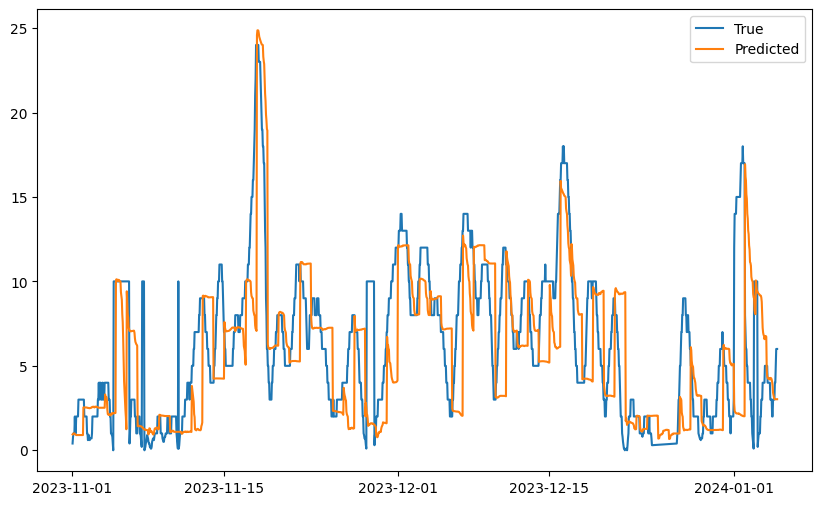

(16.28471699203581, 0.19052784387638955)

In [41]:
metrics_and_plot(preds_chor_pm10, test_chor_pm10['PM_10'])

In [42]:
series =['PM_10','Humidity','Temperature','Windspeed','WindDirection','Precipitation','Hour','Day','Month','Year','Weekday']


lags = 240
steps = 24


forecaster_cle_pm10, data_final_cle_pm10, train_cle_pm10, val_cle_pm10, test_cle_pm10 = build_model(cle_training,series, lags, steps,True)
forecaster_cle_pm10 = train_model(forecaster_cle_pm10, train_cle_pm10, 'PM_10', steps)
metrics_cle_pm10, preds_cle_pm10 = backtesting_evaluation(forecaster_cle_pm10, data_final_cle_pm10, 'PM_10', '2023-11-01 00:00:00')



Information of backtesting process
----------------------------------
Number of observations used for initial training: 16056
Number of observations used for backtesting: 1560
    Number of folds: 65
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-01-01 01:00:00 -- 2023-11-01 00:00:00  (n=16056)
    Validation: 2023-11-01 01:00:00 -- 2023-11-02 00:00:00  (n=24)
Fold: 1
    Training:   2022-01-01 01:00:00 -- 2023-11-01 00:00:00  (n=16056)
    Validation: 2023-11-02 01:00:00 -- 2023-11-03 00:00:00  (n=24)
Fold: 2
    Training:   2022-01-01 01:00:00 -- 2023-11-01 00:00:00  (n=16056)
    Validation: 2023-11-03 01:00:00 -- 2023-11-04 00:00:00  (n=24)
Fold: 3
    Training:   2022-01-01 01:00:00 -- 2023-11-04 00:00:00  (n=16128)
    Validation: 2023-11-04 01:00:00 -- 2023-11-05 00:00:00  (n=24)
Fold: 4
    Training:   2022-01-01 01:00:00 -- 2023-11-04 00:00:00  (n=16128)
    Validation: 2023-11-0

  0%|          | 0/65 [00:00<?, ?it/s]

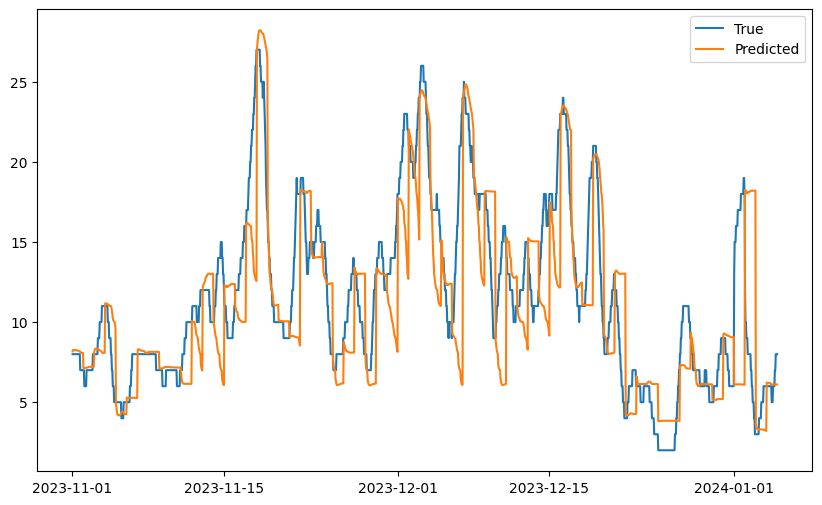

(16.032125201287887, 0.4825882540073916)

In [43]:
metrics_and_plot(preds_cle_pm10, test_cle_pm10['PM_10'])

In [44]:
forecaster_turi_pm10, data_final_turi_pm10, train_turi_pm10, val_turi_pm10, test_turi_pm10 = build_model(turi_training,series, lags, steps,True)
forecaster_turi_pm10 = train_model(forecaster_turi_pm10, train_turi_pm10, 'PM_10', steps)
metrics_turi_pm10, preds_turi_pm10 = backtesting_evaluation(forecaster_turi_pm10, data_final_turi_pm10, 'PM_10', '2023-11-01 00:00:00')


Information of backtesting process
----------------------------------
Number of observations used for initial training: 16056
Number of observations used for backtesting: 1560
    Number of folds: 65
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-01-01 01:00:00 -- 2023-11-01 00:00:00  (n=16056)
    Validation: 2023-11-01 01:00:00 -- 2023-11-02 00:00:00  (n=24)
Fold: 1
    Training:   2022-01-01 01:00:00 -- 2023-11-01 00:00:00  (n=16056)
    Validation: 2023-11-02 01:00:00 -- 2023-11-03 00:00:00  (n=24)
Fold: 2
    Training:   2022-01-01 01:00:00 -- 2023-11-01 00:00:00  (n=16056)
    Validation: 2023-11-03 01:00:00 -- 2023-11-04 00:00:00  (n=24)
Fold: 3
    Training:   2022-01-01 01:00:00 -- 2023-11-04 00:00:00  (n=16128)
    Validation: 2023-11-04 01:00:00 -- 2023-11-05 00:00:00  (n=24)
Fold: 4
    Training:   2022-01-01 01:00:00 -- 2023-11-04 00:00:00  (n=16128)
    Validation: 2023-11-0

  0%|          | 0/65 [00:00<?, ?it/s]

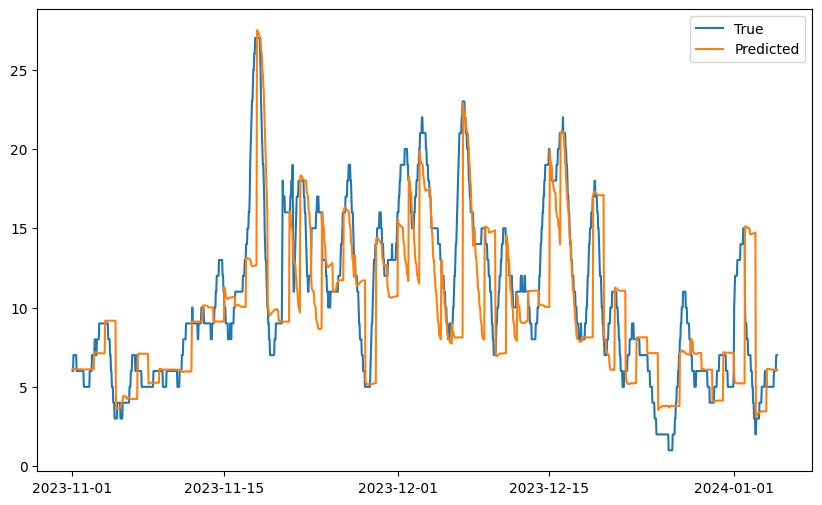

(13.333760315447627, 0.5108599304852839)

In [45]:
metrics_and_plot(preds_turi_pm10, test_turi_pm10['PM_10'])

In [46]:
forecaster_rod_pm10, data_final_rod_pm10, train_rod_pm10, val_rod_pm10, test_rod_pm10 = build_model(rod_training,series, lags, steps,True)
forecaster_rod_pm10 = train_model(forecaster_rod_pm10, train_rod_pm10, 'PM_10', steps)
metrics_rod_pm10, preds_rod_pm10 = backtesting_evaluation(forecaster_rod_pm10, data_final_rod_pm10, 'PM_10', '2023-11-01 00:00:00')

Information of backtesting process
----------------------------------
Number of observations used for initial training: 16056
Number of observations used for backtesting: 1560
    Number of folds: 65
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-01-01 01:00:00 -- 2023-11-01 00:00:00  (n=16056)
    Validation: 2023-11-01 01:00:00 -- 2023-11-02 00:00:00  (n=24)
Fold: 1
    Training:   2022-01-01 01:00:00 -- 2023-11-01 00:00:00  (n=16056)
    Validation: 2023-11-02 01:00:00 -- 2023-11-03 00:00:00  (n=24)
Fold: 2
    Training:   2022-01-01 01:00:00 -- 2023-11-01 00:00:00  (n=16056)
    Validation: 2023-11-03 01:00:00 -- 2023-11-04 00:00:00  (n=24)
Fold: 3
    Training:   2022-01-01 01:00:00 -- 2023-11-04 00:00:00  (n=16128)
    Validation: 2023-11-04 01:00:00 -- 2023-11-05 00:00:00  (n=24)
Fold: 4
    Training:   2022-01-01 01:00:00 -- 2023-11-04 00:00:00  (n=16128)
    Validation: 2023-11-0

  0%|          | 0/65 [00:00<?, ?it/s]

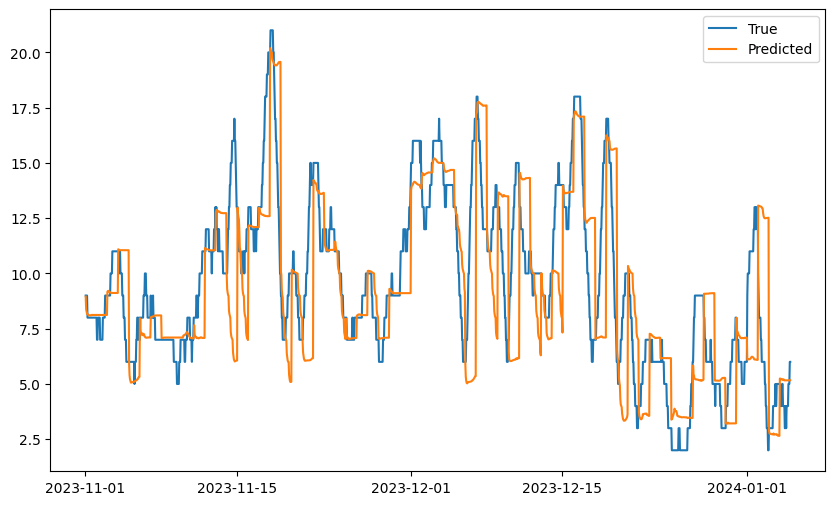

(9.834330616945769, 0.32089640423214527)

In [47]:
metrics_and_plot(preds_rod_pm10, test_rod_pm10['PM_10'])

### NO2

In [60]:
series = ['NO2', 'Humidity', 'Temperature', 'Windspeed', 'WindDirection', 'Precipitation', 'Hour', 'Day', 'Month', 'Year', 'Weekday']

# Define steps and lags
steps = 5


lags = list(range(1, 61)) + list(range(65, 76)) + list(range(95, 106)) + list(range(115, 126)) + list(range(135, 146)) + list(range(155, 166))


forecaster_chor_no2, data_final_chor_no2, train_chor_no2, val_chor_no2, test_chor_no2 = build_model(chor_training,series, lags, steps,True)
forecaster_chor_no2 = train_model(forecaster_chor_no2, train_chor_no2, 'NO2', steps)
metrics_chor_no2, preds_chor_no2 = backtesting_evaluation(forecaster_chor_no2, data_final_chor_no2, 'NO2', '2023-11-01 00:00:00')

Information of backtesting process
----------------------------------
Number of observations used for initial training: 16056
Number of observations used for backtesting: 1560
    Number of folds: 65
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-01-01 01:00:00 -- 2023-11-01 00:00:00  (n=16056)
    Validation: 2023-11-01 01:00:00 -- 2023-11-02 00:00:00  (n=24)
Fold: 1
    Training:   2022-01-01 01:00:00 -- 2023-11-01 00:00:00  (n=16056)
    Validation: 2023-11-02 01:00:00 -- 2023-11-03 00:00:00  (n=24)
Fold: 2
    Training:   2022-01-01 01:00:00 -- 2023-11-01 00:00:00  (n=16056)
    Validation: 2023-11-03 01:00:00 -- 2023-11-04 00:00:00  (n=24)
Fold: 3
    Training:   2022-01-01 01:00:00 -- 2023-11-04 00:00:00  (n=16128)
    Validation: 2023-11-04 01:00:00 -- 2023-11-05 00:00:00  (n=24)
Fold: 4
    Training:   2022-01-01 01:00:00 -- 2023-11-04 00:00:00  (n=16128)
    Validation: 2023-11-0

  0%|          | 0/65 [00:00<?, ?it/s]

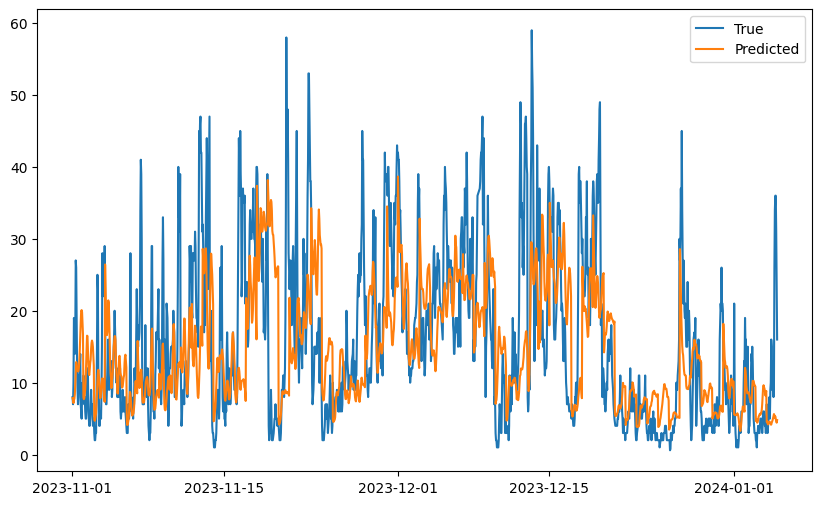

(112.32725301416745, 0.17746868838111418)

In [61]:
metrics_and_plot(preds_chor_no2, test_chor_no2['NO2'])

In [62]:
forecaster_cle_no2, data_final_cle_no2, train_cle_no2, val_cle_no2, test_cle_no2 = build_model(cle_training,series, lags, steps,True)
forecaster_cle_no2 = train_model(forecaster_cle_no2, train_cle_no2, 'NO2', steps)
metrics_cle_no2, preds_cle_no2 = backtesting_evaluation(forecaster_cle_no2, data_final_cle_no2, 'NO2', '2023-11-01 00:00:00')

Information of backtesting process
----------------------------------
Number of observations used for initial training: 16056
Number of observations used for backtesting: 1560
    Number of folds: 65
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-01-01 01:00:00 -- 2023-11-01 00:00:00  (n=16056)
    Validation: 2023-11-01 01:00:00 -- 2023-11-02 00:00:00  (n=24)
Fold: 1
    Training:   2022-01-01 01:00:00 -- 2023-11-01 00:00:00  (n=16056)
    Validation: 2023-11-02 01:00:00 -- 2023-11-03 00:00:00  (n=24)
Fold: 2
    Training:   2022-01-01 01:00:00 -- 2023-11-01 00:00:00  (n=16056)
    Validation: 2023-11-03 01:00:00 -- 2023-11-04 00:00:00  (n=24)
Fold: 3
    Training:   2022-01-01 01:00:00 -- 2023-11-04 00:00:00  (n=16128)
    Validation: 2023-11-04 01:00:00 -- 2023-11-05 00:00:00  (n=24)
Fold: 4
    Training:   2022-01-01 01:00:00 -- 2023-11-04 00:00:00  (n=16128)
    Validation: 2023-11-0

  0%|          | 0/65 [00:00<?, ?it/s]

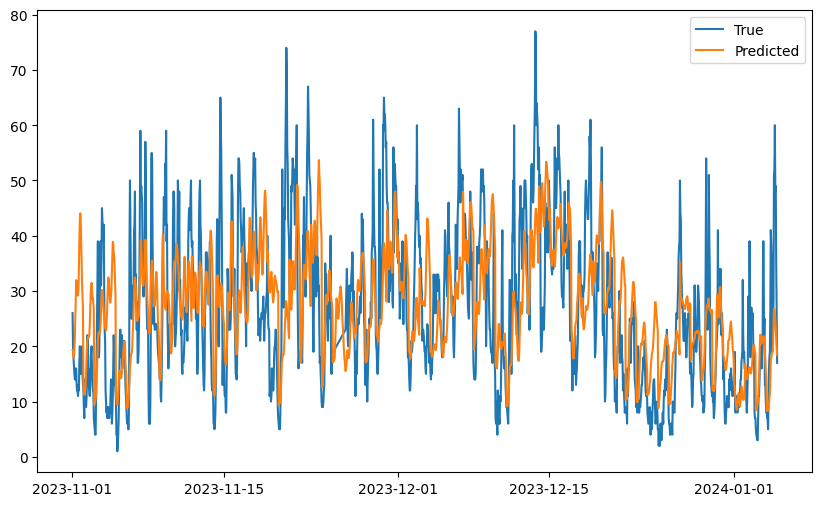

(132.8106197187245, 0.3256392529301536)

In [63]:
metrics_and_plot(preds_cle_no2, test_cle_no2['NO2'])

In [64]:
forecaster_turi_no2, data_final_turi_no2, train_turi_no2, val_turi_no2, test_turi_no2 = build_model(turi_training,series, lags, steps,True)
forecaster_turi_no2 = train_model(forecaster_turi_no2, train_turi_no2, 'NO2', steps)
metrics_turi_no2, preds_turi_no2 = backtesting_evaluation(forecaster_turi_no2, data_final_turi_no2, 'NO2', '2023-11-01 00:00:00')


Information of backtesting process
----------------------------------
Number of observations used for initial training: 16056
Number of observations used for backtesting: 1560
    Number of folds: 65
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-01-01 01:00:00 -- 2023-11-01 00:00:00  (n=16056)
    Validation: 2023-11-01 01:00:00 -- 2023-11-02 00:00:00  (n=24)
Fold: 1
    Training:   2022-01-01 01:00:00 -- 2023-11-01 00:00:00  (n=16056)
    Validation: 2023-11-02 01:00:00 -- 2023-11-03 00:00:00  (n=24)
Fold: 2
    Training:   2022-01-01 01:00:00 -- 2023-11-01 00:00:00  (n=16056)
    Validation: 2023-11-03 01:00:00 -- 2023-11-04 00:00:00  (n=24)
Fold: 3
    Training:   2022-01-01 01:00:00 -- 2023-11-04 00:00:00  (n=16128)
    Validation: 2023-11-04 01:00:00 -- 2023-11-05 00:00:00  (n=24)
Fold: 4
    Training:   2022-01-01 01:00:00 -- 2023-11-04 00:00:00  (n=16128)
    Validation: 2023-11-0

  0%|          | 0/65 [00:00<?, ?it/s]

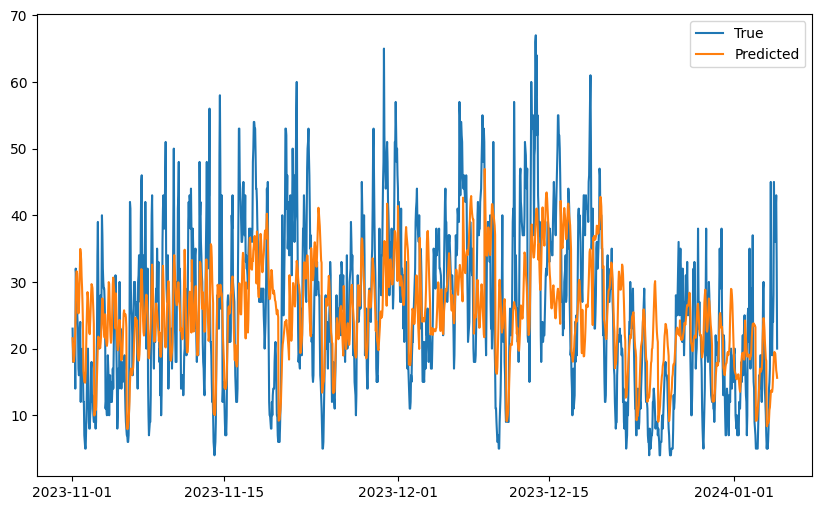

(105.85860199674588, 0.31869707209425124)

In [65]:
metrics_and_plot(preds_turi_no2, test_turi_no2['NO2'])

In [66]:
forecaster_rod_no2, data_final_rod_no2, train_rod_no2, val_rod_no2, test_rod_no2 = build_model(rod_training,series, lags, steps,True)
forecaster_rod_no2 = train_model(forecaster_rod_no2, train_rod_no2, 'NO2', steps)
metrics_rod_no2, preds_rod_no2 = backtesting_evaluation(forecaster_rod_no2, data_final_rod_no2, 'NO2', '2023-11-01 00:00:00')

Information of backtesting process
----------------------------------
Number of observations used for initial training: 16056
Number of observations used for backtesting: 1560
    Number of folds: 65
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-01-01 01:00:00 -- 2023-11-01 00:00:00  (n=16056)
    Validation: 2023-11-01 01:00:00 -- 2023-11-02 00:00:00  (n=24)
Fold: 1
    Training:   2022-01-01 01:00:00 -- 2023-11-01 00:00:00  (n=16056)
    Validation: 2023-11-02 01:00:00 -- 2023-11-03 00:00:00  (n=24)
Fold: 2
    Training:   2022-01-01 01:00:00 -- 2023-11-01 00:00:00  (n=16056)
    Validation: 2023-11-03 01:00:00 -- 2023-11-04 00:00:00  (n=24)
Fold: 3
    Training:   2022-01-01 01:00:00 -- 2023-11-04 00:00:00  (n=16128)
    Validation: 2023-11-04 01:00:00 -- 2023-11-05 00:00:00  (n=24)
Fold: 4
    Training:   2022-01-01 01:00:00 -- 2023-11-04 00:00:00  (n=16128)
    Validation: 2023-11-0

  0%|          | 0/65 [00:00<?, ?it/s]

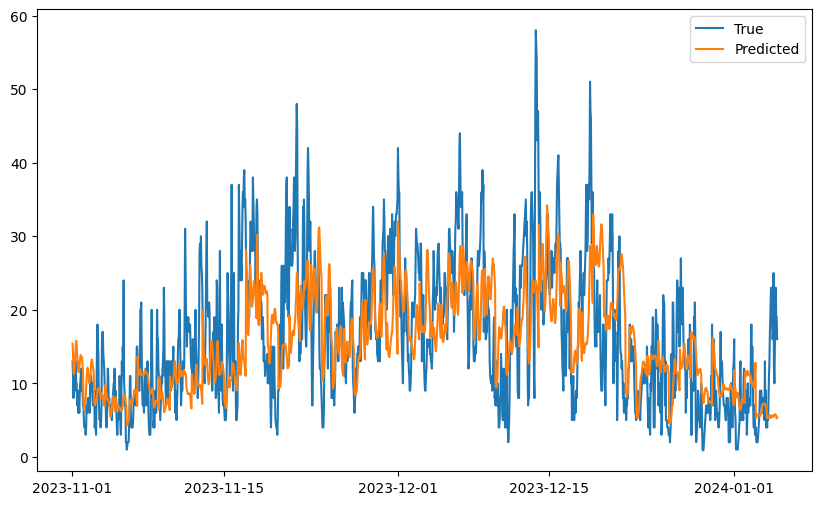

(60.813203045185595, 0.325360723028133)

In [67]:
metrics_and_plot(preds_rod_no2, test_rod_no2['NO2'])

In [70]:
chor_training.dropna(inplace=True)
rod_training.dropna(inplace= True)

In [85]:
series = ['O3', 'Humidity', 'Temperature', 'Windspeed', 'WindDirection', 'Precipitation', 'Hour', 'Day', 'Month', 'Year', 'Weekday']

# Define steps and lags
steps = 5


lags = 36


forecaster_chor_o3, data_final_chor_o3, train_chor_o3, val_chor_o3, test_chor_o3 = build_model(chor_training,series, lags, steps,True)
forecaster_chor_o3 = train_model(forecaster_chor_o3, train_chor_o3, 'O3', steps)
metrics_chor_o3, preds_chor_o3 = backtesting_evaluation(forecaster_chor_o3, data_final_chor_o3, 'O3', '2023-11-01 00:00:00')

Information of backtesting process
----------------------------------
Number of observations used for initial training: 16055
Number of observations used for backtesting: 1560
    Number of folds: 65
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-01-01 02:00:00 -- 2023-11-01 00:00:00  (n=16055)
    Validation: 2023-11-01 01:00:00 -- 2023-11-02 00:00:00  (n=24)
Fold: 1
    Training:   2022-01-01 02:00:00 -- 2023-11-01 00:00:00  (n=16055)
    Validation: 2023-11-02 01:00:00 -- 2023-11-03 00:00:00  (n=24)
Fold: 2
    Training:   2022-01-01 02:00:00 -- 2023-11-01 00:00:00  (n=16055)
    Validation: 2023-11-03 01:00:00 -- 2023-11-04 00:00:00  (n=24)
Fold: 3
    Training:   2022-01-01 02:00:00 -- 2023-11-04 00:00:00  (n=16127)
    Validation: 2023-11-04 01:00:00 -- 2023-11-05 00:00:00  (n=24)
Fold: 4
    Training:   2022-01-01 02:00:00 -- 2023-11-04 00:00:00  (n=16127)
    Validation: 2023-11-0

  0%|          | 0/65 [00:00<?, ?it/s]

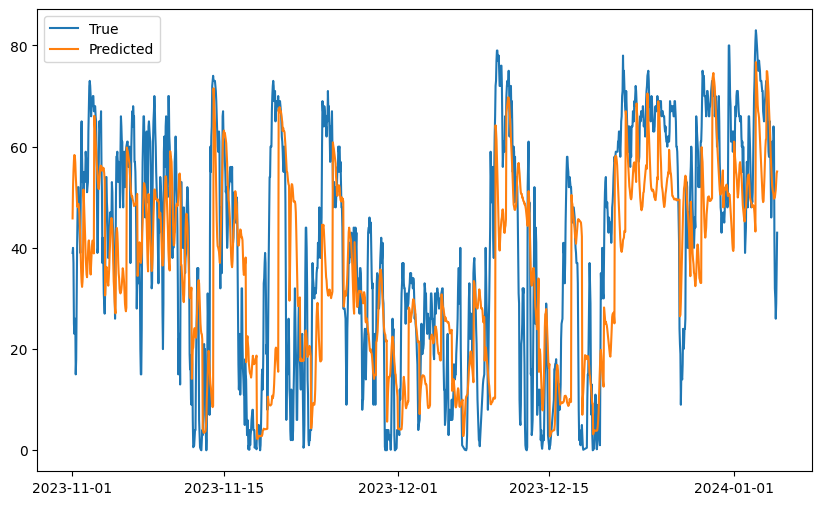

(340.9092292437882, 0.35498384693796603)

In [86]:

metrics_and_plot(preds_chor_o3, test_chor_o3['O3'])

In [78]:
forecaster_chor_o3

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  24  48  72  96 120 144 168 192 216 240 264 288
 312 336 360 384 408 432 456 480 504 528 552 576 600 624 648 672 696 720] 


Information of backtesting process
----------------------------------
Number of observations used for initial training: 7968
Number of observations used for backtesting: 1560
    Number of folds: 65
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-12-04 01:00:00 -- 2023-11-01 00:00:00  (n=7968)
    Validation: 2023-11-01 01:00:00 -- 2023-11-02 00:00:00  (n=24)
Fold: 1
    Training:   2022-12-04 01:00:00 -- 2023-11-01 00:00:00  (n=7968)
    Validation: 2023-11-02 01:00:00 -- 2023-11-03 00:00:00  (n=24)
Fold: 2
    Training:   2022-12-04 01:00:00 -- 2023-11-01 00:00:00  (n=7968)
    Validation: 2023-11-03 01:00:00 -- 2023-11-04 00:00:00  (n=24)
Fold: 3
    Training:   2022-12-04 01:00:00 -- 2023-11-04 00:00:00  (n=8040)
    Validation: 2023-11-04 01:00:00 -- 2023-11-05 00:00:00  (n=24)
Fold: 4
    Training:   2022-12-04 01:00:00 -- 2023-11-04 00:00:00  (n=8040)
    Validation: 2023-11-05 01:0

  0%|          | 0/65 [00:00<?, ?it/s]

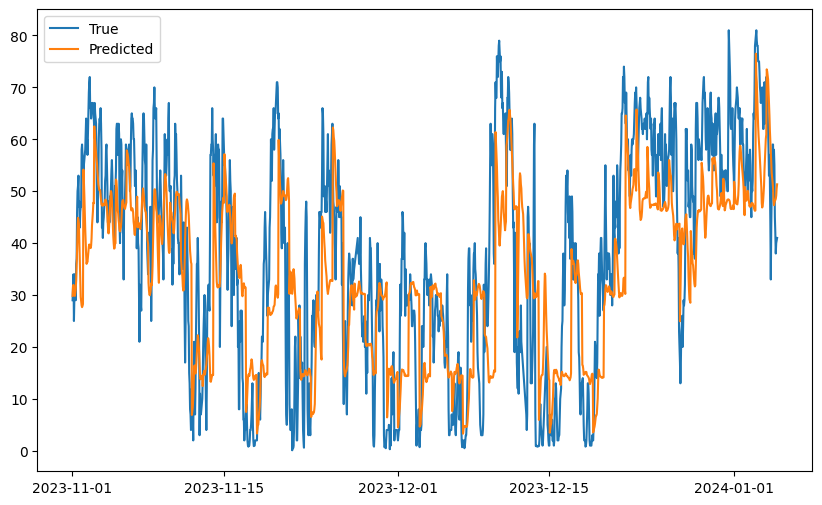

(246.12378940938768, 0.4626713033305412)

In [87]:
forecaster_rod_o3, data_final_rod_o3, train_rod_o3, val_rod_o3, test_rod_o3 = build_model(rod_training,series, lags, steps,True)
forecaster_rod_o3 = train_model(forecaster_rod_o3, train_rod_o3, 'O3', steps)
metrics_rod_o3, preds_rod_o3 = backtesting_evaluation(forecaster_rod_o3, data_final_rod_o3, 'O3', '2023-11-01 00:00:00')
metrics_and_plot(preds_rod_o3, test_rod_o3['O3'])